# AutoML Regression


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In [1]:
import sys
print("Version Python : ", sys.version)

Version Python :  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-03-10 15:09:22.936059


In [3]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.83


In [4]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import azureml.dataprep as dprep
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

## 1. Création expérimentation

In [5]:
ws = Workspace.from_config()

experiment_name = 'Exemple3-automlregression'
project_folder = './sample_projects/workshop3'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.83
Workspace Name,AzureMLWorkshop
Resource Group,AzureMLWorkshopRG
Location,westeurope
Project Directory,./sample_projects/workshop3
Experiment Name,Exemple3-automlregression


## 2. Chargement des données

In [6]:
from sklearn.datasets import load_boston
boston=load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

df['target'] = boston.target

In [7]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


In [9]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


In [10]:
df.shape

(506, 14)

In [11]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

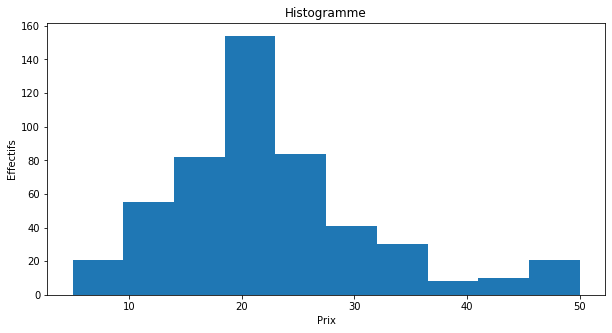

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df.target)
plt.title('Histogramme')
plt.xlabel('Prix')
plt.ylabel('Effectifs')
plt.show()

## 3. Configuration AutoML


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [13]:
# Variable à modéliser
label ="target"

In [14]:
automl_settings = {
    "enable_early_stopping": True, 
    "iterations" : 10,
    "n_cross_validations": 3,
    "primary_metric": 'r2_score',
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'automl3.log',
                             preprocess=True,
                             training_data = df,
                             label_column_name = label,
                             **automl_settings
                            )

## 4. AutoML

In [15]:
%%time
automl_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_d3fb02b2-20d0-46b0-8cc9-1d974e192482

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************************************
Current status:

In [16]:
automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple3-automlregression,AutoML_d3fb02b2-20d0-46b0-8cc9-1d974e192482,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
# Widget
from azureml.widgets import RunDetails
RunDetails(automl_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## 5. Référencement du meilleur modèle

In [19]:
best_run, fitted_model = automl_run.get_output()
print(best_run)
print(fitted_model)
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Run(Experiment: Exemple3-automlregression,
Id: AutoML_d3fb02b2-20d0-46b0-8cc9-1d974e192482_8,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...4444444444444444, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.2222222222222222]))]),
          stddev=None)
spearman_correlation 0.9298764601611031
explained_variance 0.8829692753748106
residuals aml://artifactId/ExperimentRun/dcid.AutoML_d3fb02b2-20d0-46b0-8cc9-1d974e192482_8/residuals
median_absolute_error 1.4045447673146665
predicted_true aml://artifactId/ExperimentRun/dcid.AutoML_d3fb02b2-20d0-46b0-8cc9-1d974e192482_8/predicted_true
r2_score 0.8823064055329451
normalized_root_mean_squared_e

In [20]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Exemple3-AutoML-Regression',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'R2': best_run_metrics['r2_score'], 'RMSE': best_run_metrics['normalized_root_mean_squared_error']})

Model(workspace=Workspace.create(name='AzureMLWorkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AzureMLWorkshopRG'), name=Exemple3-AutoML-Regression, id=Exemple3-AutoML-Regression:1, version=1, tags={'Training context': 'Azure Auto ML'}, properties={'R2': '0.8823064055329451', 'RMSE': '0.06954349242467574'})

In [21]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Exemple3-AutoML-Regression version = 1
	 Training context : Azure Auto ML
	 R2 : 0.8823064055329451
	 RMSE : 0.06954349242467574


Exemple2-AutoML-Classif version = 1
	 Training context : Azure Auto ML
	 AUC : 0.9992557112092131
	 Accuracy : 0.9652407308963173


Exemple4-AutoML-Forecast version = 1
	 Training context : Azure Auto ML
	 R2 : 0.2102297702988311
	 RMSE : 0.025719636958220327


IBM_attrition_explainer version = 1


local_deploy_model version = 1


boston_model.pkl version = 1
	 algo : Regression
	 type : sklearn




<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">